What we need is a small parcel to work on, with a nice contourplot with critical points and minima found after initiating local method and then a 3d plot. 

In [1]:
using Globtim
include("../../src/lib_func.jl")

# Constants and Parameters
d = 8 # Initial Degree 
const n, a, b = 2, 10, 1 
const scale_factor = a / b       # Scaling factor appears in `main_computation`, maybe it should be a parameter.
const delta, alpha = .9 , 8 / 10  # Sampling parameters
const tol_l2 = 3e-2             # Define the tolerance for the L2-norm

f = HolderTable # Objective function

SystemError: SystemError: opening file "/home/georgy/Globtim/docs/src/lib_func.jl": No such file or directory

We need to also return the number of samples used to generate the sample set. It is annoying that the error goes up while the degree has increased.

In [18]:
while true # Potential infinite loop
    global poly_approx = MainGenerate(f, 2, d, delta, alpha, scale_factor, 0.2) # computes the approximant in Chebyshev basis
    if poly_approx.nrm < tol_l2
        println("attained the desired L2-norm: ", poly_approx.nrm)
        break
    else
        println("current L2-norm: ", poly_approx.nrm)
        println("Number of samples: ", poly_approx.N)
        global d += 1
    end
end

current L2-norm: 0.13977000520430374
Number of samples: 17
current L2-norm: 0.14610574337109164
Number of samples: 21
current L2-norm: 0.09673343342005382
Number of samples: 24
current L2-norm: 0.08481826305698707
Number of samples: 28
current L2-norm: 0.06291648136134713
Number of samples: 31
current L2-norm: 0.05628709439275139
Number of samples: 35
current L2-norm: 0.04458610720652814
Number of samples: 39
current L2-norm: 0.03944771049106684
Number of samples: 44
current L2-norm: 0.03175614685423272
Number of samples: 48
attained the desired L2-norm: 0.028994267211687668


We define the file names

In [19]:
# Assuming x is already defined as @polyvar x[1:2]
loc = "inputs.ms"
# File path of the output file
file_path_output = "outputs.ms";

We now expand the approximant computed in the tensorized Chebyshev basis into standard monomial basis.

In [20]:
using DynamicPolynomials, DataFrames
ap = main_nd(n, d, poly_approx.coeffs) 
@polyvar(x[1:n]) # Define polynomial ring 
# Expand the polynomial approximant to the standard monomial basis in the Lexicographic order w.r.t x
names = [x[i].name for i in 1:length(x)]
open(loc, "w") do file
    println(file, join(names, ", "))
    println(file, 0)
end
# Define the polynomial approximant 
PolynomialApproximant = sum(ap .* MonomialVector(x, 0:d))
for i in 1:n
    partial = differentiate(PolynomialApproximant, x[i])
    partial_str = replace(string(partial), "//" => "/")
    open(loc, "a") do file
        if i < n
            println(file, string(partial_str, ","))
        else
            println(file, partial_str)
        end
    end
end

Solve with Msolve

In [21]:
run(`msolve -v 1 -f inputs.ms -o outputs.ms`)


--------------- INPUT DATA ---------------
#variables                       2
#equations                       2
#invalid equations               0
field characteristic             0
homogeneous input?               0
signature-based computation      0
monomial order                 DRL
basis hash table resetting     OFF
linear algebra option            2
initial hash table size     131072 (2^17)
max pair selection             ALL
reduce gb                        1
#threads                         1
info level                       1
generate pbm files               0
------------------------------------------
Dimension of quotient: 256
[256, 16], Non trivial / Trivial = 6.25%
Density of non-trivial part 86.33%
Time spent to generate sequence (elapsed): 0.00 sec (0.52 Gops/sec)
Time spent to compute eliminating polynomial (elapsed): 0.00 sec
Elimination polynomial has degree 256.

Starts multi-modular computations
{2}{4}{8}{16}{32}{64}{128}
<Step:2/0.00/0.01>[0][1]
248 primes used
Tim


---------------- TIMINGS ---------------
overall(elapsed)        0.00 sec
overall(cpu)            0.00 sec
select                  0.00 sec  12.9%
symbolic prep.          0.00 sec  37.0%
update                  0.00 sec   5.5%
convert                 0.00 sec  18.0%
linear algebra          0.00 sec  15.2%
reduce gb               0.00 sec   0.0%
-----------------------------------------

---------- COMPUTATIONAL DATA -----------
size of basis                    17
#terms in basis                3704
#pairs reduced                   17
#GM criterion                   136
#redundant elements               1
#rows reduced                    51
#zero reductions                  1
max. matrix data                 35 x 290 (76.562%)
max. symbolic hash table size  2^11
max. basis hash table size     2^16
-----------------------------------------



Elapsed time (real root extraction) = 1.73
------------------------------------------------------------------------------------
msolve overall time          45.16 sec (elapsed) / 45.13 sec (cpu)
------------------------------------------------------------------------------------


Process(`msolve -v 1 -f inputs.ms -o outputs.ms`, ProcessExited(0))

In [22]:
function average(X::Vector{Int})::Float64
    return sum(X) / length(X)
end

# Process the file and get the points
evaled = process_output_file(file_path_output)

# Parse the points into correct format
real_pts = []
for pts in evaled
    if typeof(pts)== Vector{Vector{Vector{BigInt}}}
        X = parse_point(pts)
    else 
        X = average.(pts) 
    end
    push!(real_pts, Float64.(X))
end;

Sort through the critical points, make sure they fall into the domain of definition. Make them into a Dataframe.

In [23]:
condition(point) = -1 < point[1] < 1 && -1 < point[2] < 1
filtered_points = filter(condition, real_pts) # Filter points using the filter function
# Colllect the critical points of the approximant 
h_x = Float64[point[1] for point in filtered_points] # Initialize the x vector for critical points of approximant
h_y = Float64[point[2] for point in filtered_points] # Initialize the y vector
h_z = map(p -> f([p[1], p[2]]), zip(scale_factor * h_x, scale_factor * h_y))
df = DataFrame(x=scale_factor * h_x, y=scale_factor * h_y, z= h_z) # Create a DataFrame

Row,x,y,z
,Float64,Float64,Float64
1,-9.44041,-9.91466,-0.396103
2,9.44041,-9.91466,-0.396103
3,-6.21331,-9.91135,-0.940167
4,6.21331,-9.91135,-0.940167
5,4.65792,-9.8429,-10.7471
6,-4.65792,-9.8429,-10.7471
7,-8.15127,-9.82645,-18.843
8,8.15127,-9.82645,-18.843
9,2.2128,-9.82414,-6.6958


In [24]:
using PlotlyJS, Colors
# Generate the grid and evaluate the function
N = 60  # resolution of the grid
x = range(-scale_factor, scale_factor, length=N)
y = range(-scale_factor, scale_factor, length=N)
z = [f([xi, yi]) for yi in y, xi in x]

60×60 Matrix{Float64}:
 -15.1402   -6.03908   -2.45697   …  -2.45697   -6.03908   -15.1402
 -16.2648   -6.47914   -2.63248      -2.63248   -6.47914   -16.2648
 -15.45     -6.14631   -2.49385      -2.49385   -6.14631   -15.45
 -13.0546   -5.18631   -2.10142      -2.10142   -5.18631   -13.0546
  -9.55245  -3.78978   -1.5334       -1.5334    -3.78978    -9.55245
  -5.46706  -2.16594   -0.875124  …  -0.875124  -2.16594    -5.46706
  -1.31072  -0.518551  -0.209212     -0.209212  -0.518551   -1.31072
  -2.46579  -0.974142  -0.392449     -0.392449  -0.974142   -2.46579
  -5.51038  -2.17384   -0.874479     -0.874479  -2.17384    -5.51038
  -7.59165  -2.99062   -1.20127      -1.20127   -2.99062    -7.59165
   ⋮                              ⋱                        
  -5.51038  -2.17384   -0.874479     -0.874479  -2.17384    -5.51038
  -2.46579  -0.974142  -0.392449     -0.392449  -0.974142   -2.46579
  -1.31072  -0.518551  -0.209212     -0.209212  -0.518551   -1.31072
  -5.46706  -2.16594   -0.

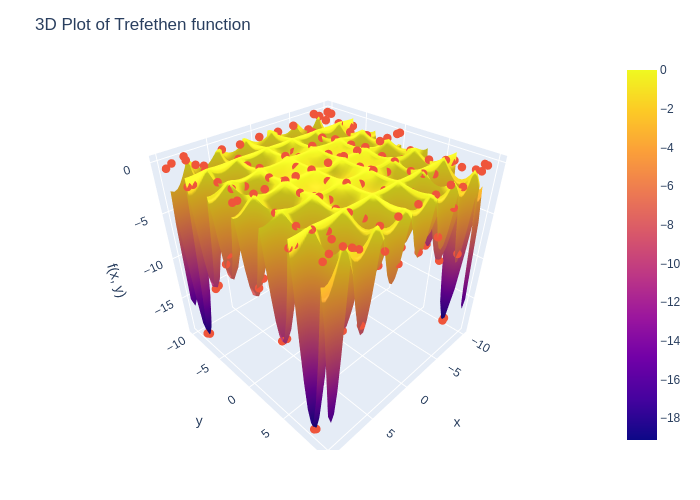

In [25]:
sf = surface(x=x, y=y, z=z)
# Had to switch the coordinates of the critical points to match the surface plot for some reason. 
crit_pts = scatter3d(x=df.y, y=df.x, z=df.z, mode="markers", marker_size=5, name="Critical Points")

# Layout for the plot
layout = Layout(title="3D Plot of H\"older function",
    scene=attr(
        xaxis_title="x",
        yaxis_title="y",
        zaxis_title="f(x, y)"),
        height=800
)
# Display the plot layout,
plot([sf,  crit_pts], layout)

Now we want to run some Optimization on the points computed to try to refine them.

In [26]:
# Optimize the collected entries 
using Optim, LinearAlgebra
for i in 1:nrow(df)
    println("Optimizing for point $i")
    x0 = [df.x[i], df.y[i]]
    try
        res = Optim.optimize(f, x0, LBFGS(), Optim.Options(show_trace=true))
        minimizer = Optim.minimizer(res)
        min_value = Optim.minimum(res)
        steps = res.iterations
        converged = Optim.converged(res)
        distance = norm(x0 - minimizer)

        println(summary(res))
    catch e
        println("Optimization failed for point $i with error: ", e)
    end
end


Optimizing for point 1
Iter     Function value   Gradient norm 
     0    -3.961027e-01     2.542942e+01
 * time: 4.315376281738281e-5
     1   -2.864658e+275    1.830985e+275
 * time: 0.00019812583923339844
     2   -3.124853e+275    1.894522e+275
 * time: 0.00028896331787109375
     3   -3.264833e+275    1.973433e+275
 * time: 0.0003440380096435547
     4   -3.264886e+275    1.973351e+275
 * time: 0.00039505958557128906
     5   -3.264886e+275    1.973351e+275
 * time: 0.00045108795166015625
     6   -3.264886e+275    1.973351e+275
 * time: 0.0004990100860595703
     7   -3.264886e+275    1.973351e+275
 * time: 0.0005481243133544922
L-BFGS
Optimizing for point 2
Iter     Function value   Gradient norm 
     0    -3.961027e-01     2.542942e+01
 * time: 1.2159347534179688e-5
     1   -2.864658e+275    1.830985e+275
 * time: 8.511543273925781e-5
     2   -3.124853e+275    1.894522e+275
 * time: 0.00014710426330566406
     3   -3.264833e+275    1.973433e+275
 * time: 0.000195980072021484

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /home/georgy/.julia/packages/LineSearches/G1LRk/src/hagerzhang.jl:148
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /home/georgy/.julia/packages/LineSearches/G1LRk/src/hagerzhang.jl:148


Optimizing for point 45
Iter     Function value   Gradient norm 
     0    -7.708034e+00     1.577200e+01
 * time: 2.8133392333984375e-5
     1    -3.226931e+44     1.197477e+44
 * time: 0.0002701282501220703
     2    -3.226971e+44     1.197051e+44
 * time: 0.0004570484161376953
     3    -3.442071e+44     2.200834e+42
 * time: 0.0005300045013427734
     4    -3.442142e+44     1.035162e+40
 * time: 0.0005881786346435547
     5    -3.442142e+44     5.887696e+34
 * time: 0.0006480216979980469
     6    -3.442142e+44     3.270942e+33
 * time: 0.0007259845733642578
     7    -3.442142e+44     4.623055e+32
 * time: 0.0007860660552978516
     8    -3.442142e+44     1.005012e+31
 * time: 0.0008761882781982422
     9    -3.442142e+44     2.311527e+32
 * time: 0.0009450912475585938
    10    -3.442142e+44     1.005012e+31
 * time: 0.0010051727294921875
    11    -3.442142e+44     1.065313e+33
 * time: 0.0011069774627685547
    12   -8.464383e+193    1.607754e+193
 * time: 0.0012090206146240234

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /home/georgy/.julia/packages/LineSearches/G1LRk/src/hagerzhang.jl:148


     3    -3.442071e+44     2.200834e+42
 * time: 0.00036597251892089844
     4    -3.442142e+44     1.035162e+40
 * time: 0.0005328655242919922
     5    -3.442142e+44     5.887696e+34
 * time: 0.0006368160247802734
     6    -3.442142e+44     3.270942e+33
 * time: 0.0007448196411132812
     7    -3.442142e+44     4.623055e+32
 * time: 0.0008418560028076172
     8    -3.442142e+44     1.005012e+31
 * time: 0.0009508132934570312
     9    -3.442142e+44     2.311527e+32
 * time: 0.001058816909790039
    10    -3.442142e+44     1.005012e+31
 * time: 0.0011699199676513672
    11    -3.442142e+44     1.065313e+33
 * time: 0.0014050006866455078
    12   -8.464383e+193    1.607754e+193
 * time: 0.0016219615936279297
    13   -8.592323e+193    8.621161e+191
 * time: 0.0018229484558105469
    14   -8.592718e+193    4.295635e+188
 * time: 0.0019638538360595703
    15   -8.592718e+193    1.627566e+182
 * time: 0.0021278858184814453
    16   -8.592718e+193    9.803470e+181
 * time: 0.002231836318

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /home/georgy/.julia/packages/LineSearches/G1LRk/src/hagerzhang.jl:148
